#Imports

In [1]:
%tensorflow_version 2.x

import tensorflow as tf
import tensorflow_hub as hub


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM, Dropout, Conv1D, MaxPooling1D, GRU
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences

import os
import numpy as np
import matplotlib.pylab as plt
import bz2
import re

#dark mode
plt.rc_context({'xtick.color':'w', 'ytick.color':'w', 'text.color':'w', 'axes.labelcolor':'w'})

seed=1234
np.random.seed(seed)
tf.random.set_seed(seed)

TensorFlow 2.x selected.


In [2]:
pip install kaggle --upgrade

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.6)
     |████████████████████████████████| 122kB 2.8MB/s 
ERROR: tensor2tensor 1.14.1 has requirement tensorflow-probability==0.7.0, but you'll have tensorflow-probability 0.9.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.11.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.21.0, but you'll have requests 2.22.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement six~=1.12.0, but you'll have six 1.14.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: urllib3 1.25.8
    Uninstalling urllib3-1.25.8:
      Successfully uninstalled urllib3-1.25.8


#Dataset

In [0]:
os.environ['KAGGLE_USERNAME'] = "fakestorm99"
os.environ['KAGGLE_KEY'] = "f823d99d37fd321c2833201b2cc358d5"

In [4]:
!kaggle datasets download bittlingmayer/amazonreviews

amazonreviews.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
os.listdir()

['.config',
 'train.ft.txt.bz2',
 'amazonreviews.zip',
 'test.ft.txt.bz2',
 'sample_data']

In [6]:
!unzip -o 'amazonreviews.zip'

Archive:  amazonreviews.zip
  inflating: test.ft.txt.bz2         
  inflating: train.ft.txt.bz2        


In [6]:
os.listdir()

['.config',
 'train.ft.txt.bz2',
 'amazonreviews.zip',
 'test.ft.txt.bz2',
 'sample_data']

In [0]:
def get_labels_and_texts(file):
    labels = []
    texts = []
    for line in bz2.BZ2File(file):
        x = line.decode("utf-8")
        labels.append(int(x[9]) - 1)
        texts.append(x[10:].strip())
    return np.array(labels), texts
train_labels, train_texts = get_labels_and_texts('train.ft.txt.bz2')
test_labels, test_texts = get_labels_and_texts('test.ft.txt.bz2')


In [0]:

NON_ALPHANUM = re.compile(r'[\W]')
NON_ASCII = re.compile(r'[^a-z0-1\s]')
def normalize_texts(texts):
    normalized_texts = []
    for text in texts:
        lower = text.lower()
        no_punctuation = NON_ALPHANUM.sub(r' ', lower)
        no_non_ascii = NON_ASCII.sub(r'', no_punctuation)
        normalized_texts.append(no_non_ascii)
    return normalized_texts

train_texts = normalize_texts(train_texts)
test_texts = normalize_texts(test_texts)

In [0]:
MAX_FEATURES = 1200

tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(train_texts)
train_texts = tokenizer.texts_to_sequences(train_texts)
test_texts = tokenizer.texts_to_sequences(test_texts)

In [0]:
MAX_LENGTH = max(len(train_ex) for train_ex in train_texts)
train_texts = pad_sequences(train_texts, maxlen=MAX_LENGTH)
test_texts = pad_sequences(test_texts, maxlen=MAX_LENGTH)

In [19]:
encoder = info.features['text'].encoder
print ('Vocabulary size: {}'.format(encoder.vocab_size))

NameError: ignored

In [0]:
sample_input = 'Hello, world!'
encoded = encoder.encode(sample_input)
decoded = encoder.decode(encoded)
print(encoded, decoded, "\n")

for index in encoded:
  print('{}\t-> {}'.format(index, encoder.decode([index])))

[4025, 8040, 2, 562, 7962] Hello, world! 

4025	-> Hell
8040	-> o
2	-> , 
562	-> world
7962	-> !


In [0]:
BATCH_SIZE = 64
BUFFER_SIZE = 10000

In [12]:
print('train_text shape:', train_texts.shape)
print(train_texts.shape[0], 'train samples')
print(test_texts.shape[0], 'test samples')

train_text shape: (3600000, 245)
3600000 train samples
400000 test samples


#Model

In [0]:
EPOCHS = 1
STEPS_PER_EPOCH = 32
VALIDATION_STEPS = 16

In [0]:
def train(model, epochs=EPOCHS):
  model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

  return model.fit(train_texts, train_labels, epochs=epochs,
                      batch_size=BATCH_SIZE, 
                      steps_per_epoch=STEPS_PER_EPOCH,
                      validation_data=(test_texts, test_labels),
                      validation_steps=VALIDATION_STEPS
                      )

In [0]:
def plot_accuracy_and_loss(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(10, 10))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.setp(plt.legend().get_texts(), color='black')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1.0])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.setp(plt.legend().get_texts(), color='black')
  plt.ylabel('Cross Entropy')
  plt.ylim([0.0,1.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

##Bidirectional LSTM

In [31]:
model = Sequential([
    Embedding(MAX_FEATURES, 32, mask_zero=True),
    Bidirectional(LSTM(64)),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          38400     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               49664     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 88,193
Trainable params: 88,193
Non-trainable params: 0
_________________________________________________________________


Train on 3600000 samples, validate on 400000 samples
Epoch 1/5
   2048/3600000 [..............................] - ETA: 10:21:40 - loss: 0.3858 - accuracy: 0.8325 - val_loss: 9.7322e-04 - val_accuracy: 0.8457

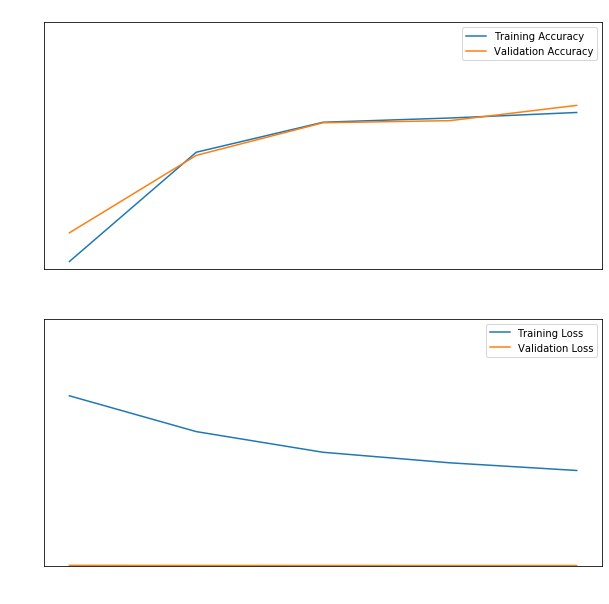

In [32]:
history = train(model)
plot_accuracy_and_loss(history)

##Stack LSTM

In [34]:
model = Sequential([
    Embedding(MAX_FEATURES, 32, mask_zero=True),
    Bidirectional(LSTM(64,  return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 32)          38400     
_________________________________________________________________
bidirectional_4 (Bidirection (None, None, 128)         49664     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 129,345
Trainable params: 129,345
Non-trainable params: 0
_________________________________________________________________


Train on 3600000 samples, validate on 400000 samples
Epoch 1/5
   2048/3600000 [..............................] - ETA: 16:16:05 - loss: 0.3309 - accuracy: 0.8604 - val_loss: 8.1866e-04 - val_accuracy: 0.8721

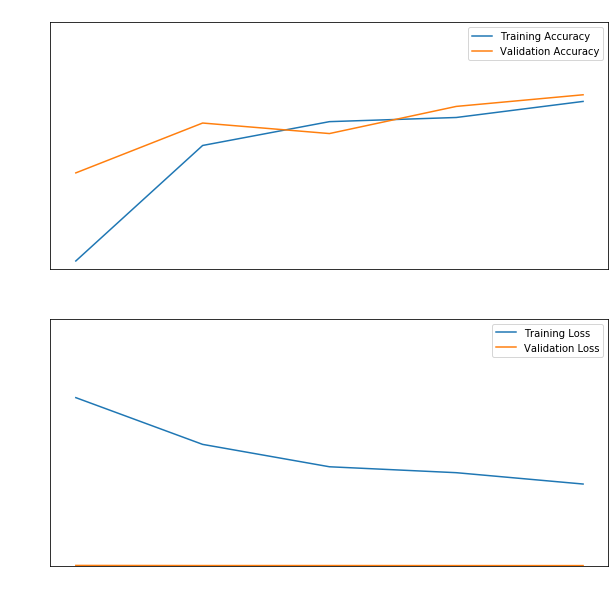

In [35]:
history = train(model)
plot_accuracy_and_loss(history)

##ConvNet

In [0]:
model = Sequential([
    Embedding(MAX_FEATURES, 32, mask_zero=True),
    Conv1D(32, 3, padding='same', activation = 'relu'),
    MaxPooling1D(2),
    Bidirectional(LSTM(64)),
    Dense(1, activation='sigmoid')
])

Train on 3600000 samples, validate on 400000 samples
Epoch 1/10
   2048/3600000 [..............................] - ETA: 2:59:28 - loss: 0.3122 - accuracy: 0.8706 - val_loss: 8.5909e-04 - val_accuracy: 0.8613

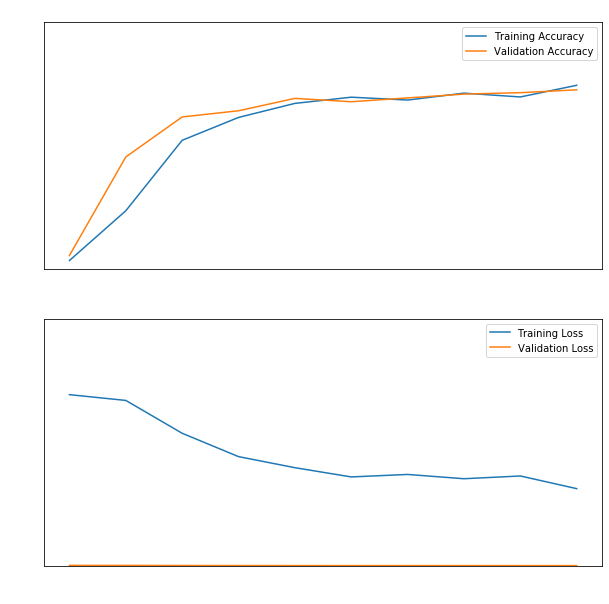

In [37]:
history = train(model, epochs=10)
plot_accuracy_and_loss(history)

##GRU

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 32)          38400     
_________________________________________________________________
gru (GRU)                    (None, 64)                18816     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 57,281
Trainable params: 57,281
Non-trainable params: 0
_________________________________________________________________
Train on 3600000 samples, validate on 400000 samples
Epoch 1/5
   2048/3600000 [..............................] - ETA: 4:52:29 - loss: 0.3815 - accuracy: 0.8335 - val_loss: 9.8093e-04 - val_accuracy: 0.8398

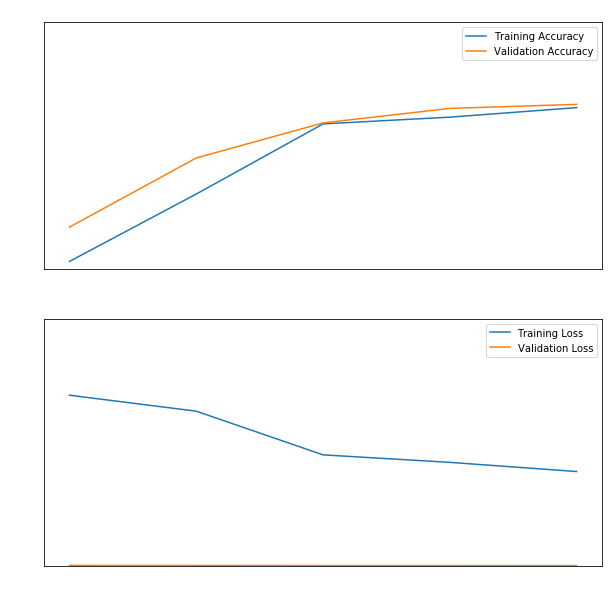

In [38]:
model = Sequential([
    Embedding(MAX_FEATURES, 32, mask_zero=True),
    GRU(64),
    Dense(1, activation='sigmoid')
])

model.summary()

history = train(model)
plot_accuracy_and_loss(history)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 32)          38400     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 128)               37632     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 79,265
Trainable params: 79,265
Non-trainable params: 0
_________________________________________________________________
Train on 3600000 samples, validate on 400000 samples
Epoch 1/10
   2048/3600000 [..............................] - E

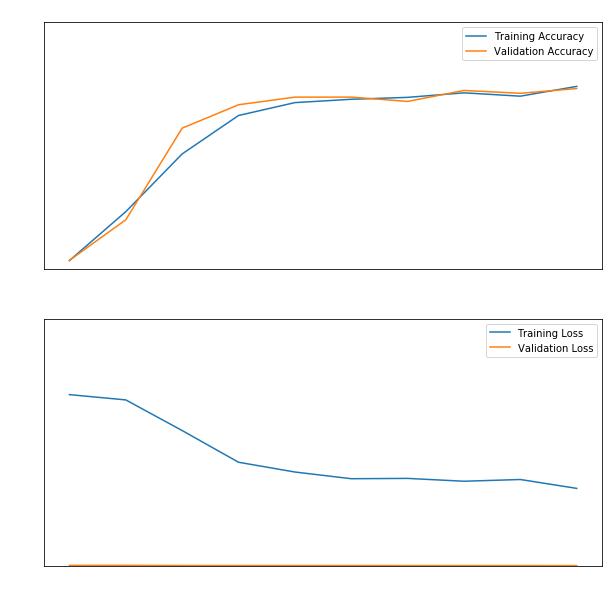

In [39]:
model = Sequential([
    Embedding(MAX_FEATURES, 32, mask_zero=True),
    Conv1D(32, 3, padding='same', activation = 'relu'),
    MaxPooling1D(2),
    Bidirectional(GRU(64)),
    Dense(1, activation='sigmoid')
])

model.summary()

history = train(model, epochs=10)
plot_accuracy_and_loss(history)

